In [67]:
import os
import tarfile
import urllib.request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zlib import crc32
from sklearn.model_selection import *
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import *
from sklearn.base import BaseEstimator, TransformerMixin



DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    # creates a directory with the path specified by housing_path using the os.makedirs function.The exist_ok=True
    # argument ensures that the function doesn't raise an error if the directory already exists.
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")  # creates a path to a file named housing.tgz within the
    # directory specified by housing_path using the os.path.join function.
    urllib.request.urlretrieve(housing_url, tgz_path)
    # downloads the file located at the housing_url URL and saves
    # it to the file specified by tgz_path using the urllib.request.urlretrieve function. These lines open the
    # tarfile specified by tgz_path, extract its contents to the directory specified by housing_path, and then close
    # the tarfile using the tarfile.open, extractall, and close methods, respectively.
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


fetch_housing_data()
housing = load_housing_data()

# homes.info()
# print(homes.describe())

# housing.hist(bins=50, figsize=(20, 15))
# plt.show()


def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 ** 32


def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]  # ~ inverts the opernad


housing_with_id = housing.reset_index()  # adds an `index` column
# train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
print(housing["ocean_proximity"].value_counts())

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64


In [7]:
housing_with_id["id"] = housing["longitude"]*1000 +housing["latitude"]
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [16]:
housing["income_cat"] = pd.cut(housing["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
labels=[1, 2, 3, 4, 5])

<AxesSubplot:>

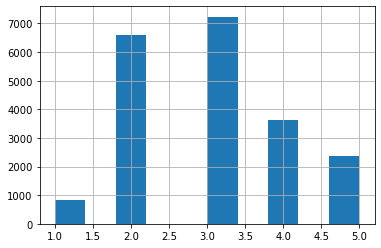

In [17]:
housing["income_cat"].hist()

In [18]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [19]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [21]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

** Let’s create a copy so that you can play with it
without harming the training set:

In [23]:
housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

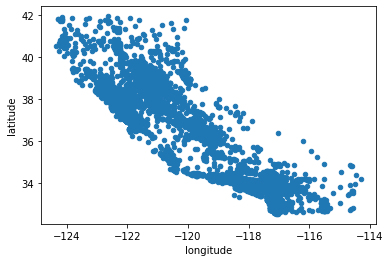

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude")

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

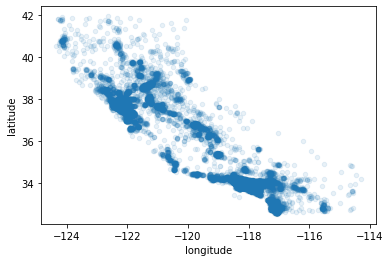

In [25]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=.1)

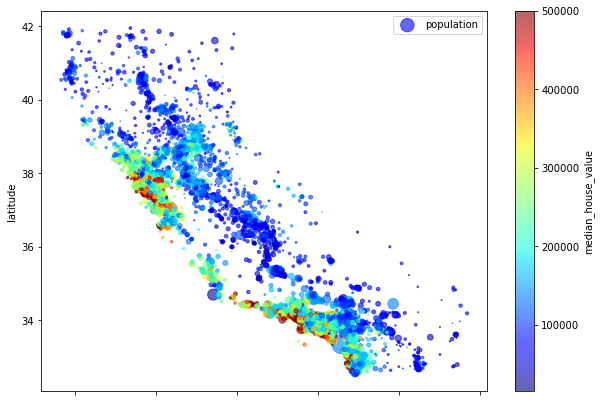

In [29]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.6,
s=housing["population"]/100, label="population", figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

In [31]:
corr_matrix = housing.corr() #standard correlation coefficient

In [32]:
### 1 - -1 si 1 relació aumenta...

In [33]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

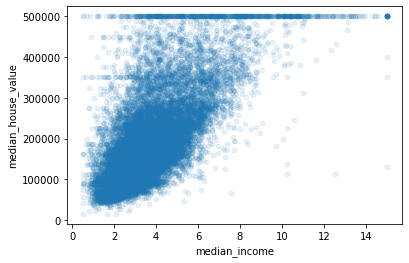

In [34]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)


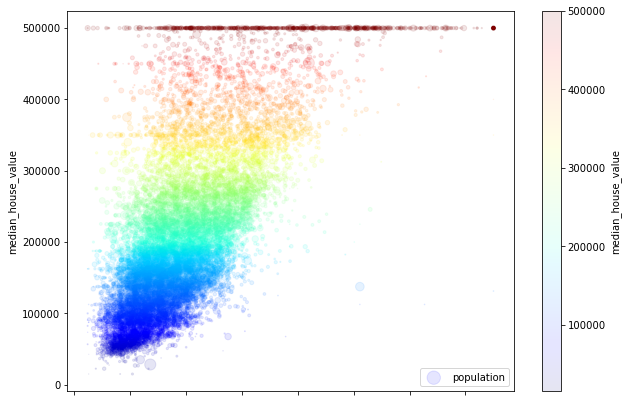

In [36]:
housing.plot(kind="scatter",x="median_income", y="median_house_value", alpha=0.1,
s=housing["population"]/100, label="population", figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

In [37]:
#We'll create some interesting combinations to look
housing["rooms_per_household"]= housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [38]:
corr_matrix = housing.corr() #standard correlation coefficient

In [42]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

In [41]:
corr_matrix["median_income"].sort_values(ascending=False)

median_income               1.000000
median_house_value          0.687151
rooms_per_household         0.311528
total_rooms                 0.200133
population_per_household    0.021815
households                  0.010869
population                  0.002421
total_bedrooms             -0.009643
longitude                  -0.019615
latitude                   -0.075146
housing_median_age         -0.111315
bedrooms_per_room          -0.624650
Name: median_income, dtype: float64

In [40]:
#clean training set
housing = strat_train_set.drop("median_house_value", axis=1) # create a DataFrame containing only the input features that will be used to train a machine learning model.
housing_labels = strat_train_set["median_house_value"].copy()

In [ ]:
#We cannot work with  missing features, the total_bedrooms attribute has some missing values
housing.dropna(subset=["total_bedrooms"]) # Get rid of the corresponding districts.
housing.drop("total_bedrooms", axis=1) # Get rid of the whole attribute
median = housing["total_bedrooms"].median() # Set the values to some value (zero, the mean, the median, etc.).
housing["total_bedrooms"].fillna(median, inplace=True)

In [45]:
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)

In [48]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [49]:
imputer.statistics_#imputer has simply computed the median of each attribute and stored the  result in its statistics_ instance variable.

array([-1.1849e+02,  3.4260e+01,  2.9000e+01,  2.1270e+03,  4.3500e+02,
        1.1660e+03,  4.0900e+02,  3.5348e+00,  1.7970e+05])

In [50]:
housing_num.median().values

array([-1.1849e+02,  3.4260e+01,  2.9000e+01,  2.1270e+03,  4.3500e+02,
        1.1660e+03,  4.0900e+02,  3.5348e+00,  1.7970e+05])

In [51]:
X = imputer.transform(housing_num)#we put it back into the model

In [54]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
index=housing_num.index)

In [55]:
#Handling Text and Categorical Attributes

In [57]:
housing_cat = housing[["ocean_proximity"]]

In [58]:
housing_cat

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY
...,...
20635,INLAND
20636,INLAND
20637,INLAND
20638,INLAND


In [68]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.]])

In [63]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [69]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<20640x5 sparse matrix of type '<class 'numpy.float64'>'
	with 20640 stored elements in Compressed Sparse Row format>